# TP 1 RL : Dynamic programing

L'objectif de ce TP est de se familiariser avec la programmation dynamique pour le calcul de fonction de valeur d'état et de politique. Nous nous commencerons avec un environnement très simple : un griddworld de taille $10\times 10$. 

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from time import sleep
from IPython.display import clear_output
import math
import numpy.matlib
import imageio

In [ ]:
#@title Utils functions 

def plot_pi(pi):
  plt.xticks(np.arange(-1, N+1, 1))
  plt.yticks(np.arange(-1, N+1, 1))
  plt.grid( which='major')

  param = {'lw':3,
           'head_width':2/N}
  for i in range(pi.shape[0]):
    ll = pi[i,:]
    x = i%N
    y = N - math.ceil((i+1)/N)
    args = np.argwhere(ll>0)
    for n in args:
      if n==0:
        plt.arrow(x,y,.5,0,**param)
      elif n==1:
        plt.arrow(x,y,0,.5,**param)
      elif n==2:
        plt.arrow(x,y,-.5,0,**param)
      elif n==3:
        plt.arrow(x,y,0,-.5,**param)

def get_next_Vij(V_2d,i,j):
  if i<0 or i>N or j<0 or j>N: 
    raise ValueError("indices must be between 0 and N")
  if i==0:
    if j==N-1:
      ll = (-1e3,-1e3,V_2d[i,j-1],V_2d[i+1,j])
    else:
      ll = (V_2d[i,j+1],-1e3,V_2d[i,j-1],V_2d[i+1,j])
  elif j==0:
    if i==N-1:
      ll = (V_2d[i,j+1],V_2d[i-1,j],-1e3,-1e3)
    else:
      ll = (V_2d[i,j+1],V_2d[i-1,j],-1e3,V_2d[i+1,j])
  elif i==N-1:
    ll = (V_2d[i,j+1],V_2d[i-1,j],V_2d[i,j-1],-1e3)
  elif j==N-1:
    ll = (-1e3,V_2d[i-1,j],V_2d[i,j-1],V_2d[i+1,j])
  else:
    ll = (V_2d[i,j+1],V_2d[i-1,j],V_2d[i,j-1],V_2d[i+1,j])
  return ll


def get_Ppi(P,pi):

  P = np.zeros([N**2,N**2])
  p = 1
  pi = np.array(pi)
  if pi.size == 4:
    pi = np.matlib.repmat(pi,N**2,1)
  
  for i in range(N):
    for j in range(N):
      s   = i*N+j
      s_E = i*N+j+1
      s_N = (i-1)*N+j
      s_O = i*N+j-1
      s_S = (i+1)*N+j

      if j < N-1:
        P[s,s_E] = p*pi[i*N+j,0]
      else :
        P[s,s] = p*pi[i*N+j,0]
      if i > 0:
        P[s,s_N] = p*pi[i*N+j,1]
      else :
        P[s,s] = p*pi[i*N+j,1]
      if j > 0:
        P[s,s_O] = p*pi[i*N+j,2]
      else :
        P[s,s] = p*pi[i*N+j,2]
      if i < N-1:
        P[s,s_S] = p*pi[i*N+j,3]
      else :
        P[s,s] = p*pi[i*N+j,3]
      if (i,j)==(0,N-1):
        P[s,s] = p*pi[i*N+j,0] + p*pi[i*N+j,1]
      if (i,j)==(N-1,0):
        P[s,s] = p*pi[i*N+j,2] + p*pi[i*N+j,3]

  P[0,:] = 0
  P[N**2-1,:]=0

  return P


## Partie 1 : Initialisation

Pour commencer nous allons définir la dynamique du modèle et en particulier la matrice de transition $\mathcal P$ du griddworld ainsi que la matrice de récompense $\mathcal R^\pi \in \mathbb R^{N,N}$ pour une politique de mouvement uniforme avec une probabilité $\pi = 0.25$ constante et récompense constante poour chaque état $r = -1$ sauf pour les états terminaux $(0,0)$ et $(N,N)$ où $r=0$. 

In [ ]:
N = 10
R = -1*np.ones([N**2,1])
R[0] = 0
R[N**2-1] = 0

Création de la matrice de transition pour une politique de mouvements uniforme avec une probailité $\pi$ = 0.25 et une transition déterministe $p(s' | s, a) = 1$ pour $s'$ situé en $E,N,O$ ou $S$ par rapport à $s$.

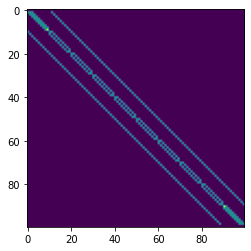

In [ ]:
P = np.zeros([N**2,N**2])
p = 1
pi = .25

for i in range(N):
  for j in range(N):
    s   = i*N+j
    s_E = i*N+j+1
    s_N = (i-1)*N+j
    s_O = i*N+j-1
    s_S = (i+1)*N+j

    if j < N-1:
      P[s,s_E] = p*pi
    else :
      P[s,s] = p*pi
    if i > 0:
      P[s,s_N] = p*pi
    else :
      P[s,s] = p*pi
    if j > 0:
      P[s,s_O] = p*pi
    else :
      P[s,s] = p*pi
    if i < N-1:
      P[s,s_S] = p*pi
    else :
      P[s,s] = p*pi
    if (i,j)==(0,N-1) or (i,j)==(N-1,0):
      P[s,s] = p*2*pi

P[0,:] = 0
P[N**2-1,:]=0

plt.imshow(P)

## Partie 2 : Estimation de la politique et de la valeur des états associée

In [ ]:
def get_V(iter,P,R,gamma,show=1):
  V = np.zeros([N**2,1])
  for n in range(iter):
    V = R + gamma*P@V
    if show and n % 100 == 99:
      clear_output()
      plt.imshow(np.reshape(V,[N,N]))
      plt.title(f'Iteration = {n+1}')
      plt.show()
      sleep(1)
  return V

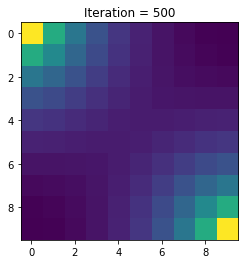

In [ ]:
V = np.zeros([N**2,1])
gamma = 1
n_iter = 500

fig = plt.figure()

V = get_V(n_iter,P,R,gamma)
  

**Amélioration de la politique par action gloutonne** : l'évaluation de la fonction de coût associée à notre politique naive nous permet de mettre en évidence une politique $\pi' \geq \pi$. 

In [ ]:
def greedy_policy(V):
  V_2d = np.reshape(V,[N,N])
  pi = np.zeros([N**2,4])

  for i in range(N):
    for j in range(N):
      if i==0 and j==0 or i==N-1 and j==N-1:
          continue
      V_voisin = get_next_Vij(V_2d,i,j)
      args = np.argwhere(V_voisin==np.max(V_voisin))
      pi[i*N+j,args] = 1/len(args)
  
  return pi

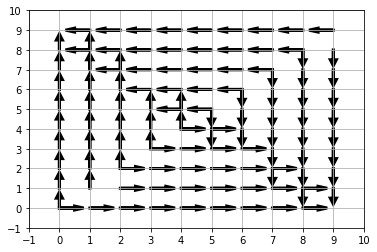

In [ ]:
pi = greedy_policy(V)
plot_pi(pi)

## Partie 3 : Maximisation de la politique

Dans le cas précédent, tout l'espace était exploré, conduisant à découvrir la politique optimale après une seule itération. A présent, nous allons initialiser notre politique en faisant le choix d'aller toujours à l'est puis améliorer la politique de façon gloutonne une fois la fonction de valeur estimée.

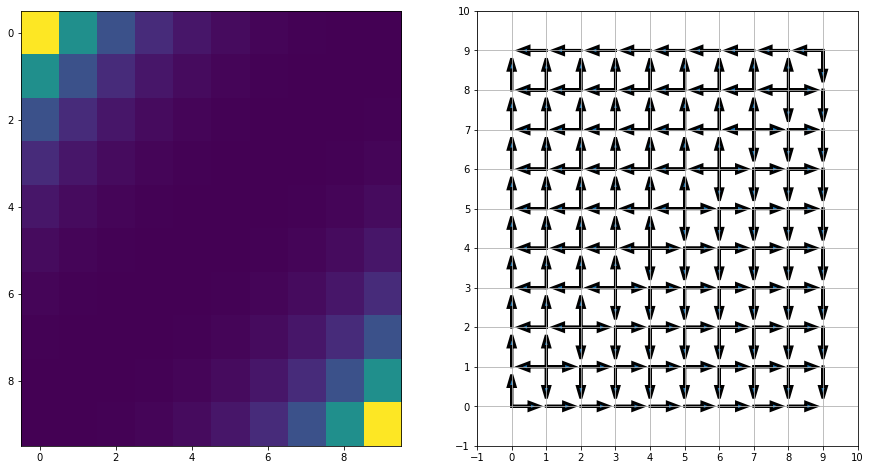

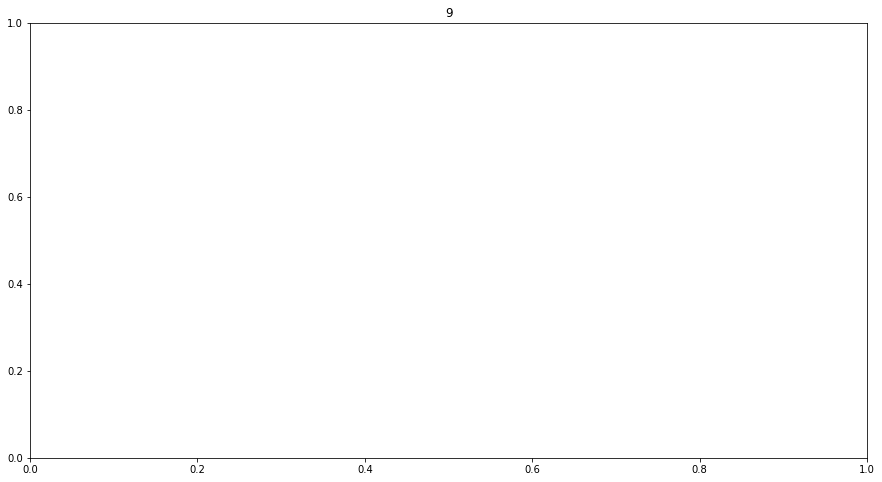

In [ ]:
iter_total = 10
iter_policy = 100
show = 1
show_every = 1
gamma = .5

plt.rcParams['figure.figsize'] = [15, 8]

P_pi = get_Ppi([1,0,0,0],P)

fig, axs = plt.subplots(12)
  

for i in range(iter_total):
  V = get_V(iter_policy,P_pi,R,gamma,show=0)
  pi = greedy_policy(V)
  P_pi = get_Ppi(P,pi)
  if show and i % show_every == 0:
    clear_output()
    
    plt.subplot(121)
    plt.imshow(np.reshape(V,[N,N]), aspect="auto")
    axs[0].set_title('Value Function')
    plt.subplot(122)
    plot_pi(pi)
    axs[1].set_title('Next policy')
    plt.show()
    plt.title(i)
    sleep(4)

# Partie 4 : Labyrinthe

A présent évaluons la valeur des différents états ainsi que la politique optimale pour un labyrinthe. Le labyrinthe est donné par la matrice suivante : 

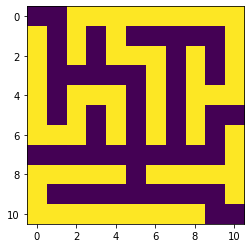

In [ ]:
maze =   np.array([[0,0,1,1,1,1,1,1,1,1,1],
                  [1,0,1,0,1,0,0,0,0,0,1],
                  [1,0,1,0,1,1,1,0,1,0,1],
                  [1,0,0,0,0,0,1,0,1,0,1],
                  [1,0,1,1,1,0,1,0,1,1,1],
                  [1,0,1,0,1,0,1,0,1,0,0],
                  [1,1,1,0,1,0,1,0,1,0,1],
                  [0,0,0,0,0,0,0,0,0,0,1],
                  [1,1,1,1,1,0,1,1,1,1,1],
                  [1,0,0,0,0,0,0,0,0,0,1],
                  [1,1,1,1,1,1,1,1,1,0,0]])

plt.imshow(maze)

**À vous de jouer !**

À vous de réécrire les matrices de transition et de récompense pour ce nouveau problème. 